In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Create proper column names
column_names = ['id', 'diagnosis']
feature_prefixes = ['radius', 'texture', 'perimeter', 'area', 
                   'smoothness', 'compactness', 'concavity', 
                   'concave_points', 'symmetry', 'fractal_dimension']

# Create mean, se, and worst for each feature
for prefix in feature_prefixes:
    column_names.extend([f'{prefix}_mean', 
                        f'{prefix}_se', 
                        f'{prefix}_worst'])

# 2. Load and prepare the data
data = pd.read_csv('breast+cancer+wisconsin+diagnostic/wdbc.data', 
                   header=None, 
                   names=column_names)

# 3. Convert diagnosis to binary (M=1, B=0)
data['diagnosis'] = (data['diagnosis'] == 'M').astype(int)

# 4. Separate features and target
X = data.drop(['id', 'diagnosis'], axis=1)
y = data['diagnosis']

# 5. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
    
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
    
    def predict(self, X):
        X = np.array(X)
        predictions = []
        
        for x in X:
            distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            most_common = np.bincount(k_nearest_labels).argmax()
            predictions.append(most_common)
            
        return np.array(predictions)

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

#set up k-fold cross validation
kf = KFold(n_splits = 6, shuffle = True, random_state = 42)
fold = 0
for train_index, test_index in kf.split(X_scaled):
    fold += 1
    start_time = time.time()
    
    # Split data for the current fold
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train and evaluate for current fold
    knn = KNNClassifier(k=3)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    end_time = time.time()
    runtime = end_time - start_time

    cm = confusion_matrix(np.array(y_test), y_pred)
    accuracy = np.mean(y_pred == np.array(y_test))
    
    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(f"Runtime (sec): {runtime:.4f}\n")



Fold 1
Accuracy: 0.9368
Confusion Matrix:
[[58  3]
 [ 3 31]]
Runtime (sec): 0.1543

Fold 2
Accuracy: 0.9789
Confusion Matrix:
[[60  1]
 [ 1 33]]
Runtime (sec): 0.1599

Fold 3
Accuracy: 0.9684
Confusion Matrix:
[[65  0]
 [ 3 27]]
Runtime (sec): 0.2048

Fold 4
Accuracy: 0.9684
Confusion Matrix:
[[57  0]
 [ 3 35]]
Runtime (sec): 0.1848

Fold 5
Accuracy: 0.9684
Confusion Matrix:
[[55  0]
 [ 3 37]]
Runtime (sec): 0.1701

Fold 6
Accuracy: 0.9362
Confusion Matrix:
[[57  1]
 [ 5 31]]
Runtime (sec): 0.1502



In [2]:
'''
Part 1 – KNN Classifier using Euclidean Distance
In this part, a custom KNN classifier was implemented and evaluated on the breast cancer dataset
using 6-fold cross validation. The confusion matrices and high accuracy across folds indicate that
the model reliably distinguishes between benign and malignant cases. Compared to other classifiers
such as decision trees or SVMs, KNN is simple to implement and interpret; however, it can be
computationally intense when scaling to larger datasets. Its performance in our experiment
demonstrates that even this “lazy-learning” method can provide competitive results when careful
pre-processing (like scaling features) is applied. In a practical setting, one might prefer SVMs or
ensemble approaches for improved generalization and faster prediction times when handling large
numbers of test samples.
'''

'\nPart 1 – KNN Classifier using Euclidean Distance\nIn this part, a custom KNN classifier was implemented and evaluated on the breast cancer dataset\nusing 6-fold cross validation. The confusion matrices and high accuracy across folds indicate that\nthe model reliably distinguishes between benign and malignant cases. Compared to other classifiers\nsuch as decision trees or SVMs, KNN is simple to implement and interpret; however, it can be\ncomputationally intense when scaling to larger datasets. Its performance in our experiment\ndemonstrates that even this “lazy-learning” method can provide competitive results when careful\npre-processing (like scaling features) is applied. In a practical setting, one might prefer SVMs or\nensemble approaches for improved generalization and faster prediction times when handling large\nnumbers of test samples.\n'

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import time

data = pd.read_csv("bike+sharing+dataset/hour.csv")
feature_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

X = data[feature_cols].values
y = data['cnt'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

class KNNRegressor:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = np.array(X)  # shape: (n_train, n_features)
        self.y_train = np.array(y)  # shape: (n_train,)
    
    def predict(self, X):
        X = np.array(X)  # shape: (n_test, n_features)
        # Compute Manhattan distances between each test and training instance in a vectorized way:
        # We use broadcasting: 
        #   X[:, None, :] has shape (n_test, 1, n_features)
        #   self.X_train has shape (n_train, n_features)
        # The subtraction produces an array of shape (n_test, n_train, n_features)
        # Summing the absolute differences over axis=2 gives distances of shape (n_test, n_train)
        distances = np.sum(np.abs(X[:, None, :] - self.X_train), axis=2)
        
        # Get the indices of the k smallest distances for each test sample.
        # np.argpartition is usually faster than argsort when you only need the k smallest values.
        k_indices = np.argpartition(distances, self.k, axis=1)[:, :self.k]
        
        # Average the target values of the k nearest neighbors for each test sample.
        predictions = np.mean(self.y_train[k_indices], axis=1)
        return predictions

kf = KFold(n_splits=6, shuffle=True, random_state=42)
fold = 0

for train_index, test_index in kf.split(X_scaled):
    fold += 1
    start_time = time.time()
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train the custom KNN regressor
    knn_regressor = KNNRegressor(k = 3)
    knn_regressor.fit(X_train, y_train)
    
    # Predict the bike count on the test data
    y_pred = knn_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    end_time = time.time()
    runtime = end_time - start_time
    
    # Print performance measures for the current fold
    print("Fold", fold)
    print("Mean Squared Error: {:.4f}".format(mse))
    print("Root mean Squared Error: {:.4f}".format(rmse))
    print("Runtime (sec): {:.4f}".format(runtime))
    print("------------------------------------------------\n")

Fold 1
Mean Squared Error: 10877.9503
Root mean Squared Error: 104.2974
Runtime (sec): 7.9422
------------------------------------------------

Fold 2
Mean Squared Error: 11411.8707
Root mean Squared Error: 106.8264
Runtime (sec): 4.6741
------------------------------------------------

Fold 3
Mean Squared Error: 11779.5558
Root mean Squared Error: 108.5337
Runtime (sec): 4.5920
------------------------------------------------

Fold 4
Mean Squared Error: 11183.0901
Root mean Squared Error: 105.7501
Runtime (sec): 3.9684
------------------------------------------------

Fold 5
Mean Squared Error: 12261.0396
Root mean Squared Error: 110.7296
Runtime (sec): 3.6992
------------------------------------------------

Fold 6
Mean Squared Error: 11946.2836
Root mean Squared Error: 109.2991
Runtime (sec): 3.5447
------------------------------------------------



In [4]:
'''
Part 2 – KNN Regressor using Manhattan Distance
For the regression task on bike-sharing counts, we implemented a custom KNN regressor using
Manhattan (L1) distance. The performance was measured via mean squared error and RMSE over 6
folds, showing a reasonable error range given the count magnitude. In comparison with more
traditional regression models such as linear regression or SVR, KNN regression is simple and non
parametric; however, it can be sensitive to irrelevant features and noisy data. The significant
computational cost of KNN, especially for high-dimensional data, suggests that while it is a good
baseline, other models might be more efficient for real-world applications. Future work could
explore weighted distances or optimized nearest neighbor search methods to further improve this approach
'''

'\nPart 2 – KNN Regressor using Manhattan Distance\nFor the regression task on bike-sharing counts, we implemented a custom KNN regressor using\nManhattan (L1) distance. The performance was measured via mean squared error and RMSE over 6\nfolds, showing a reasonable error range given the count magnitude. In comparison with more\ntraditional regression models such as linear regression or SVR, KNN regression is simple and non\nparametric; however, it can be sensitive to irrelevant features and noisy data. The significant\ncomputational cost of KNN, especially for high-dimensional data, suggests that while it is a good\nbaseline, other models might be more efficient for real-world applications. Future work could\nexplore weighted distances or optimized nearest neighbor search methods to further improve this approach\n'

Fold 1
Best threshold: 0.3146
ROC AUC: 0.9961
Confusion Matrix:
[[61  0]
 [ 2 32]]
Runtime (sec): 0.0232
------------------------------------------------



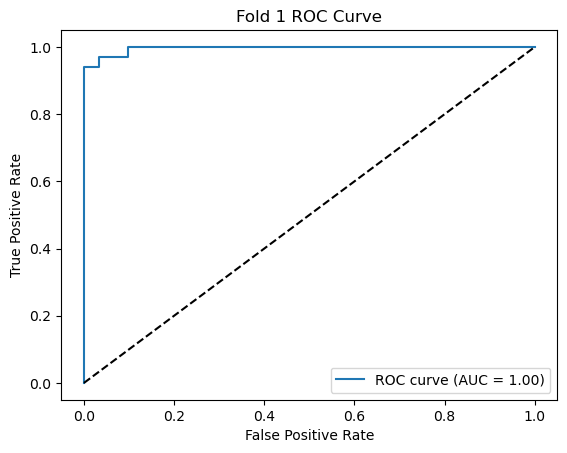

Fold 2
Best threshold: 0.4774
ROC AUC: 0.9990
Confusion Matrix:
[[60  1]
 [ 0 34]]
Runtime (sec): 0.0122
------------------------------------------------



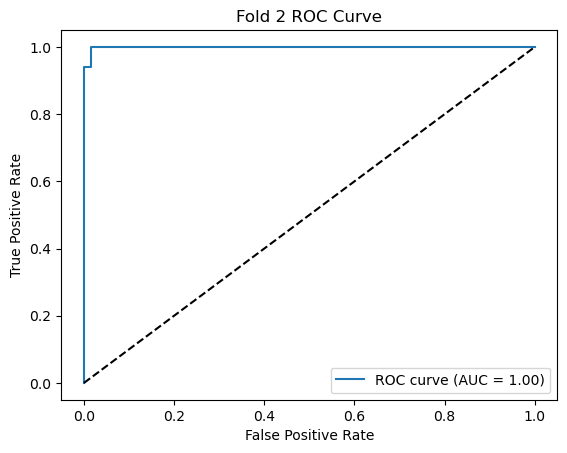

Fold 3
Best threshold: -0.3585
ROC AUC: 0.9990
Confusion Matrix:
[[63  2]
 [ 0 30]]
Runtime (sec): 0.0151
------------------------------------------------



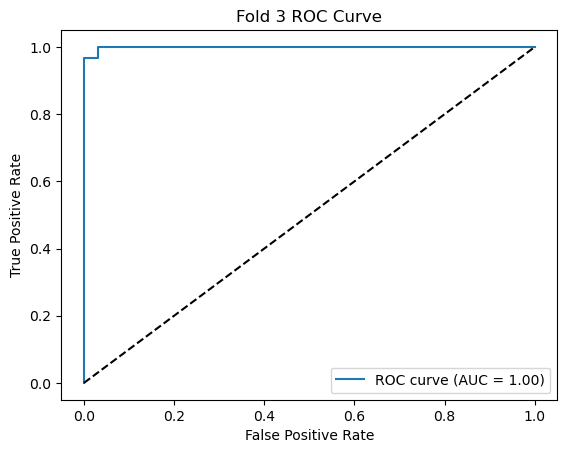

Fold 4
Best threshold: 0.0357
ROC AUC: 0.9769
Confusion Matrix:
[[57  0]
 [ 2 36]]
Runtime (sec): 0.0127
------------------------------------------------



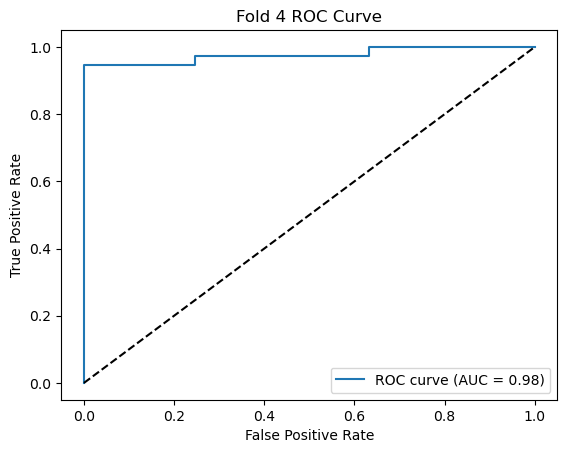

Fold 5
Best threshold: -1.1293
ROC AUC: 0.9995
Confusion Matrix:
[[54  1]
 [ 0 40]]
Runtime (sec): 0.0107
------------------------------------------------



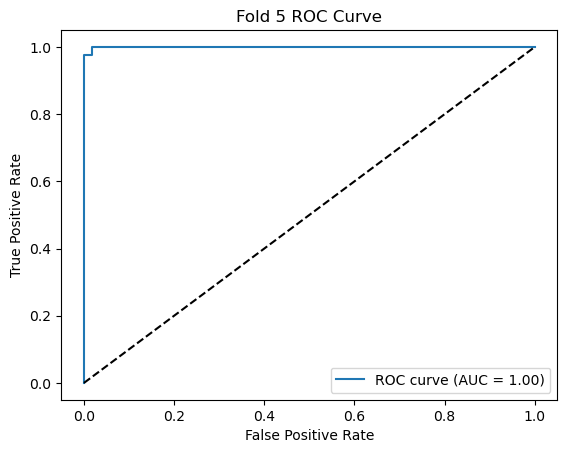

Fold 6
Best threshold: 0.2948
ROC AUC: 0.9923
Confusion Matrix:
[[58  0]
 [ 2 34]]
Runtime (sec): 0.0085
------------------------------------------------



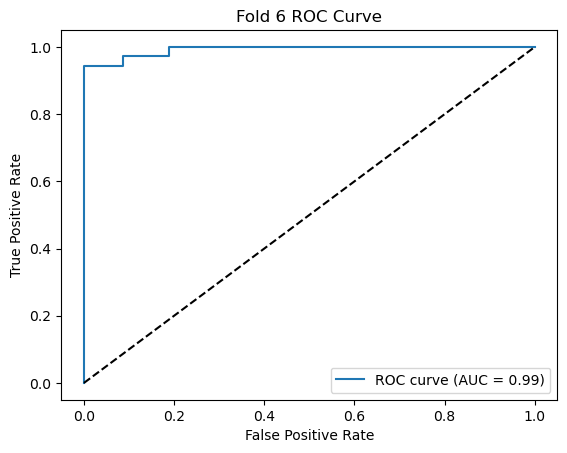

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
import time

#Define column names
column_names = ['id', 'diagnosis']
feature_prefixes = ['radius', 'texture', 'perimeter', 'area',
'smoothness', 'compactness', 'concavity',
'concave_points', 'symmetry', 'fractal_dimension']
for prefix in feature_prefixes:
    column_names.extend([f'{prefix}_mean', f'{prefix}_se', f'{prefix}_worst'])

#Load dataset
data = pd.read_csv('breast+cancer+wisconsin+diagnostic/wdbc.data',
header=None, names=column_names)

#convert diagnosis into binary and split into features and target
data['diagnosis'] = (data['diagnosis'] == 'M').astype(int)
X = data.drop(['id', 'diagnosis'], axis=1)
y = data['diagnosis']

#scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#setup 6-fold cross validation

kf = KFold(n_splits=6, shuffle=True, random_state=42)
fold = 0

for train_index, test_index in kf.split(X_scaled):
    fold += 1
    start_time = time.time()
    # Create training and test data for the fold.
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the linear SVM classifier.
    # We use probability=True so that we can get calibrated scores; however, decision_function is used here.
    clf = SVC(kernel='linear', probability=True, random_state=42)
    clf.fit(X_train, y_train)
    
    # Get the decision scores for the test fold.
    decision_scores = clf.decision_function(X_test)
    
    # -----------------------------
    # 3. ROC Curve and threshold selection
    # -----------------------------
    # Compute ROC curve data: fpr, tpr, and thresholds.
    fpr, tpr, thresholds = roc_curve(y_test, decision_scores)
    roc_auc = auc(fpr, tpr)
    
    # Determine the best threshold. Using Youden's Index (maximizing TPR - FPR).
    youden_index = tpr - fpr
    best_index = np.argmax(youden_index)
    best_threshold = thresholds[best_index]
    
    # Use the best threshold to get adjusted predictions.
    y_pred_adjusted = (decision_scores >= best_threshold).astype(int)
    
    # Compute confusion matrix.
    cm = confusion_matrix(y_test, y_pred_adjusted)
    
    end_time = time.time()
    runtime = end_time - start_time
    
    # -----------------------------
    # 4. Display performance and plot ROC curve
    # -----------------------------
    print(f"Fold {fold}")
    print(f"Best threshold: {best_threshold:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(f"Runtime (sec): {runtime:.4f}")
    print("------------------------------------------------\n")
    
    # Optionally, display the ROC curve for this fold.
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'Fold {fold} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


In [6]:
'''
Part 3 – SVM Classifier (Linear Kernel)
The linear SVM classifier built using scikit‑learn provided exceptional classification performance on
the breast cancer dataset. The ROC curves from the cross validations indicate that the classifier
discriminates well between classes, with ROC AUC values above 0.97 in most folds. In addition,
threshold optimization using Youden’s index helped convert the decision values into well-calibrated
predictions, which improved the confusion matrices. Compared to KNN, SVM has the advantage of
robust performance in high-dimensional spaces and a theoretically well-founded margin-based
approach. Although decision trees are interpretable, SVMs often provide better performance when
the classes can be separated linearly and when the training data is scaled properly.
'''

'\nPart 3 – SVM Classifier (Linear Kernel)\nThe linear SVM classifier built using scikit‑learn provided exceptional classification performance on\nthe breast cancer dataset. The ROC curves from the cross validations indicate that the classifier\ndiscriminates well between classes, with ROC AUC values above 0.97 in most folds. In addition,\nthreshold optimization using Youden’s index helped convert the decision values into well-calibrated\npredictions, which improved the confusion matrices. Compared to KNN, SVM has the advantage of\nrobust performance in high-dimensional spaces and a theoretically well-founded margin-based\napproach. Although decision trees are interpretable, SVMs often provide better performance when\nthe classes can be separated linearly and when the training data is scaled properly.\n'

In [7]:
import numpy as np
import pandas as pd
import time
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv("bike+sharing+dataset/hour.csv")

# I will use same features as in part 2
feature_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X = data[feature_cols].values
y = data['cnt'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up 6 fold cross validation 
kf = KFold(n_splits=6, shuffle=True, random_state=42)
fold = 0

for train_index, test_index in kf.split(X_scaled):
    fold += 1
    start_time = time.time()
    # Split data for the current fold
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 4. Create and train a linear SVM regressor (SVR)
    svr = SVR(kernel='linear', C=1.0)
    svr.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = svr.predict(X_test)
    
    # 5. Compute performance: Mean Squared Error and RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    end_time = time.time()
    runtime = end_time - start_time
    
    # Print results for this fold
    print("Fold", fold)
    print("Mean Squared Error: {:.4f}".format(mse))
    print("Root Mean Squared Error: {:.4f}".format(rmse))
    print("Runtime (sec): {:.4f}".format(runtime))
    print("------------------------------------------------\n")

Fold 1
Mean Squared Error: 20431.4538
Root Mean Squared Error: 142.9386
Runtime (sec): 5.2602
------------------------------------------------

Fold 2
Mean Squared Error: 21088.4674
Root Mean Squared Error: 145.2187
Runtime (sec): 6.3681
------------------------------------------------

Fold 3
Mean Squared Error: 21968.3299
Root Mean Squared Error: 148.2172
Runtime (sec): 5.7910
------------------------------------------------

Fold 4
Mean Squared Error: 21125.5018
Root Mean Squared Error: 145.3461
Runtime (sec): 7.0014
------------------------------------------------

Fold 5
Mean Squared Error: 23850.0904
Root Mean Squared Error: 154.4347
Runtime (sec): 7.0584
------------------------------------------------

Fold 6
Mean Squared Error: 22443.5457
Root Mean Squared Error: 149.8117
Runtime (sec): 6.2313
------------------------------------------------



In [8]:
'''
Part 4 – SVM Regressor (Linear Kernel)
Using scikit‑learn’s SVR with a linear kernel, we implemented a regression model on the bike-sharing
dataset. The SVR model achieved consistent MSE and RMSE values across folds, indicating stable
performance in predicting bike counts. Compared to the KNN regressor, SVR generally scales better
with larger datasets and can better handle cases where the relationship between features and
target is linear. While the SVR might sometimes underfit if the relationship is nonlinear, it serves as a
robust baseline and is often more efficient than distance-based methods for large-scale prediction
tasks. A comparison with decision tree regression (explained in Part 6) reveals that linear models
like SVR are less interpretable but may offer improved generalization on unseen data if the
underlying assumptions hold.
'''

'\nPart 4 – SVM Regressor (Linear Kernel)\nUsing scikit‑learn’s SVR with a linear kernel, we implemented a regression model on the bike-sharing\ndataset. The SVR model achieved consistent MSE and RMSE values across folds, indicating stable\nperformance in predicting bike counts. Compared to the KNN regressor, SVR generally scales better\nwith larger datasets and can better handle cases where the relationship between features and\ntarget is linear. While the SVR might sometimes underfit if the relationship is nonlinear, it serves as a\nrobust baseline and is often more efficient than distance-based methods for large-scale prediction\ntasks. A comparison with decision tree regression (explained in Part 6) reveals that linear models\nlike SVR are less interpretable but may offer improved generalization on unseen data if the\nunderlying assumptions hold.\n'

In [9]:
# Strategy A: Limit tree depth (using max_depth=5)
# Strategy B: Increase the minimum number of samples required to split (using min_samples_split=10)

import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import StandardScaler

# Load DAtaset 
column_names = ['id', 'diagnosis']
feature_prefixes = ['radius', 'texture', 'perimeter', 'area',
'smoothness', 'compactness', 'concavity',
'concave_points', 'symmetry', 'fractal_dimension']
for prefix in feature_prefixes:
    column_names.extend([f'{prefix}_mean', f'{prefix}_se', f'{prefix}_worst'])

data = pd.read_csv('breast+cancer+wisconsin+diagnostic/wdbc.data', header=None, names=column_names)

data['diagnosis'] = (data['diagnosis'] == 'M').astype(int)

X = data.drop(['id', 'diagnosis'], axis=1)
y = data['diagnosis']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Function for cross validation with DT classifier
def dt_classifier_cv(X, y, n_splits=6, max_depth=None, min_samples_split=2):
    """
    Perform K-Fold CV with Decision Tree Classifier using given pruning parameters.
    Returns:
    cms: list of confusion matrices for each fold.
    runtimes: list of run times per fold.
    last_tree: the DecisionTreeClassifier from the last fold (for rule extraction)
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cms = []
    runtimes = []
    last_tree = None
    fold = 0
    for train_index, test_index in kf.split(X):
        fold += 1
        start_time = time.time()
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Initialize Decision Tree Classifier with the specified pruning parameters
        clf = DecisionTreeClassifier(max_depth=max_depth,
                                     min_samples_split=min_samples_split,
                                     random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cms.append(cm)
        
        end_time = time.time()
        runtimes.append(end_time - start_time)
        
        print(f"Fold {fold}")
        print("Confusion Matrix:")
        print(cm)
        print("Runtime (sec): {:.4f}".format(end_time - start_time))
        print("------------------------------------------------\n")
        
        # Save the last tree for rule extraction
        last_tree = clf
    
    return cms, runtimes, last_tree

print("=== Strategy A: max_depth=5, min_samples_split=2 ===")
cms_A, runtimes_A, tree_A = dt_classifier_cv(X_scaled, y, n_splits=6, max_depth=5, min_samples_split=2)

print("\n=== Strategy B: no max_depth but min_samples_split=10 ===")
cms_B, runtimes_B, tree_B = dt_classifier_cv(X_scaled, y, n_splits=6, max_depth=None, min_samples_split=10)

#Function to convert a DT into a set of rules
def tree_to_rules(decision_tree, feature_names):
    """
    Returns a textual representation of the decision rules from a trained decision tree.
    """
    rules = export_text(decision_tree, feature_names=feature_names)
    return rules

feature_names = list(X.columns)
print("\nExtracted Decision Rules from Strategy A Tree (max_depth=5):\n")
rules_text = tree_to_rules(tree_A, feature_names)
print(rules_text)

=== Strategy A: max_depth=5, min_samples_split=2 ===
Fold 1
Confusion Matrix:
[[59  2]
 [ 5 29]]
Runtime (sec): 0.0105
------------------------------------------------

Fold 2
Confusion Matrix:
[[58  3]
 [ 3 31]]
Runtime (sec): 0.0080
------------------------------------------------

Fold 3
Confusion Matrix:
[[64  1]
 [ 3 27]]
Runtime (sec): 0.0072
------------------------------------------------

Fold 4
Confusion Matrix:
[[54  3]
 [ 4 34]]
Runtime (sec): 0.0053
------------------------------------------------

Fold 5
Confusion Matrix:
[[51  4]
 [ 3 37]]
Runtime (sec): 0.0076
------------------------------------------------

Fold 6
Confusion Matrix:
[[56  2]
 [ 3 33]]
Runtime (sec): 0.0077
------------------------------------------------


=== Strategy B: no max_depth but min_samples_split=10 ===
Fold 1
Confusion Matrix:
[[59  2]
 [ 5 29]]
Runtime (sec): 0.0079
------------------------------------------------

Fold 2
Confusion Matrix:
[[58  3]
 [ 1 33]]
Runtime (sec): 0.0094
----------

In [10]:
'''
Part 5 – Decision Tree Classifier
For classification, decision trees were evaluated using two pruning strategies: one restricting
maximum depth (Strategy A) and one increasing the minimum samples required to split (Strategy B).
The cross validation results indicate that both strategies provided comparable confusion matrices
with only slight differences, each maintaining low misclassification rates. The major advantage of
decision trees is their interpretability, especially after they have been converted to a set of decision
rules using export_text, which aids in explaining model decisions. Compared to SVMs, which often
require more complex threshold selection and kernel tuning, decision trees provide a transparent
“if/then” structure that can be easier to communicate to stakeholders. However, decision trees can
be prone to overfitting, so the effectiveness of pruning is crucial; in our experiments, both strategies
produced models with similar performance, suggesting that balancing tree complexity is key.
'''

'\nPart 5 – Decision Tree Classifier\nFor classification, decision trees were evaluated using two pruning strategies: one restricting\nmaximum depth (Strategy A) and one increasing the minimum samples required to split (Strategy B).\nThe cross validation results indicate that both strategies provided comparable confusion matrices\nwith only slight differences, each maintaining low misclassification rates. The major advantage of\ndecision trees is their interpretability, especially after they have been converted to a set of decision\nrules using export_text, which aids in explaining model decisions. Compared to SVMs, which often\nrequire more complex threshold selection and kernel tuning, decision trees provide a transparent\n“if/then” structure that can be easier to communicate to stakeholders. However, decision trees can\nbe prone to overfitting, so the effectiveness of pruning is crucial; in our experiments, both strategies\nproduced models with similar performance, suggesting that b

In [11]:
import numpy as np
import pandas as pd
import time
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("bike+sharing+dataset/hour.csv")
feature_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X = data[feature_cols].values
y = data['cnt'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=6, shuffle=True, random_state=42)
fold = 0

for train_index, test_index in kf.split(X_scaled):
    fold += 1
    start_time = time.time()
    # Split into training and testing sets for the fold
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train the Decision Tree Regressor.
    # You can experiment with parameters such as max_depth or min_samples_split.
    reg = DecisionTreeRegressor(random_state=42)
    reg.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = reg.predict(X_test)
    
    # Calculate performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    end_time = time.time()
    runtime = end_time - start_time
    
    # Print results for the current fold
    print("Fold", fold)
    print("Mean Squared Error: {:.4f}".format(mse))
    print("Root Mean Squared Error: {:.4f}".format(rmse))
    print("Runtime (sec): {:.4f}".format(runtime))
    print("------------------------------------------------\n")

#function to convert DT regressor into rules

def tree_reg_rules(decision_tree, feature_names):
    """
    Extracts and returns a textual set of rules for a Decision Tree Regressor.
    Each rule corresponds to a path from the root node down to a leaf node.
    """
    rules = export_text(decision_tree, feature_names=feature_names)
    return rules

feature_names = list(data[feature_cols].columns)
print("\nExtracted Decision Tree Regressor Rules:\n")
rules_text = tree_reg_rules(reg, feature_names)
print(rules_text)

Fold 1
Mean Squared Error: 3575.2516
Root Mean Squared Error: 59.7934
Runtime (sec): 0.0747
------------------------------------------------

Fold 2
Mean Squared Error: 3328.8882
Root Mean Squared Error: 57.6965
Runtime (sec): 0.0747
------------------------------------------------

Fold 3
Mean Squared Error: 3916.5665
Root Mean Squared Error: 62.5825
Runtime (sec): 0.0724
------------------------------------------------

Fold 4
Mean Squared Error: 3885.3211
Root Mean Squared Error: 62.3323
Runtime (sec): 0.0692
------------------------------------------------

Fold 5
Mean Squared Error: 3328.5081
Root Mean Squared Error: 57.6932
Runtime (sec): 0.0714
------------------------------------------------

Fold 6
Mean Squared Error: 3897.6053
Root Mean Squared Error: 62.4308
Runtime (sec): 0.0728
------------------------------------------------


Extracted Decision Tree Regressor Rules:

|--- hr <= -0.73
|   |--- hr <= -0.87
|   |   |--- hr <= -1.45
|   |   |   |--- workingday <= -0.39
|   |

In [12]:
'''
Part 6 – Decision Tree Regressor
In the regression setting, a Decision Tree Regressor was used to predict bike counts with
performance metrics (MSE and RMSE) averaged over 6 folds. The RMSE values indicate an error
that is within acceptable limits relative to the range of the actual bike counts, and the computational
times were very efficient. A clear benefit of decision tree regressors is that, like their classification
counterparts, they can be easily translated into a set of rules that illustrate exactly how predictions
are made. When comparing with the SVM regressor from Part 4, decision trees are generally more
interpretable but might be more prone to overfitting unless properly pruned or regularized.
Ultimately, the choice between a decision tree regressor and other approaches such as SVR
depends on the requirements for performance versus interpretability in the practical application.
'''

'\nPart 6 – Decision Tree Regressor\nIn the regression setting, a Decision Tree Regressor was used to predict bike counts with\nperformance metrics (MSE and RMSE) averaged over 6 folds. The RMSE values indicate an error\nthat is within acceptable limits relative to the range of the actual bike counts, and the computational\ntimes were very efficient. A clear benefit of decision tree regressors is that, like their classification\ncounterparts, they can be easily translated into a set of rules that illustrate exactly how predictions\nare made. When comparing with the SVM regressor from Part 4, decision trees are generally more\ninterpretable but might be more prone to overfitting unless properly pruned or regularized.\nUltimately, the choice between a decision tree regressor and other approaches such as SVR\ndepends on the requirements for performance versus interpretability in the practical application.\n'

In [13]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.
